## Домашняя работа 2


## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать:

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов:
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

%matplotlib inline

In [2]:
df = pd.read_csv('data.adult.csv')
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

В данном датасете пропущенные значения обозначены как "?".

**Задание 1** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [3]:
df.isna().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
>50K,<=50K        False
dtype: bool

In [4]:
for col in df.columns:
    print(col, (df[col].eq('?')).any())

age False
workclass True
fnlwgt False
education False
education-num False
marital-status False
occupation True
relationship False
race False
sex False
capital-gain False
capital-loss False
hours-per-week False
>50K,<=50K False


In [5]:
dfw = df[df['workclass'] != '?']
dfw

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


In [6]:
dfo = dfw[dfw['occupation'] != '?']
dfo.reset_index(drop = True , inplace = True)
dfo

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
15343,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
15344,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
15345,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем:

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [7]:
dfr = dfo
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15347 entries, 0 to 15346
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
 13  >50K,<=50K      15347 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.6+ MB


In [8]:
dfr = dfr.drop(columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
dfr['target'] = pd.factorize(dfr['>50K,<=50K'])[0]
dfr = dfr.drop(columns = ['>50K,<=50K'])
dfr

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
0,34,284843,9,594,0,60,0
1,40,190290,10,0,0,40,0
2,36,177858,13,0,0,40,0
3,22,184756,10,0,0,30,0
4,47,149700,13,15024,0,40,1
...,...,...,...,...,...,...,...
15342,25,514716,13,0,0,40,0
15343,32,207668,13,15024,0,45,1
15344,27,104457,13,0,0,40,0
15345,59,268700,9,0,0,40,0


<AxesSubplot:>

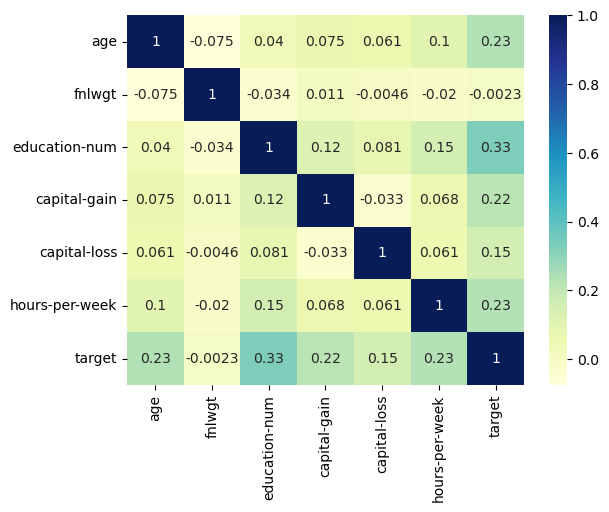

In [9]:
sns.heatmap(dfr.corr(), cmap = 'YlGnBu', annot = True)

Из вещественных переменных наибольшая корреляция у target-а с education-num.

In [10]:
dft = pd.DataFrame(dfr['target'])
dft

,target
0,0
1,0
2,0
3,0
4,1
...,...
15342,0
15343,1
15344,0
15345,0


In [11]:
dft['target'].unique()

array([0, 1], dtype=int64)

In [12]:
dfr = dfr.drop(columns = ['target'])
dfr

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
...,...,...,...,...,...,...
15342,25,514716,13,0,0,40
15343,32,207668,13,15024,0,45
15344,27,104457,13,0,0,40
15345,59,268700,9,0,0,40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)

Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

In [13]:
X = dfr
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
...,...,...,...,...,...,...
15342,25,514716,13,0,0,40
15343,32,207668,13,15024,0,45
15344,27,104457,13,0,0,40
15345,59,268700,9,0,0,40


In [14]:
y = dft
y

,target
0,0
1,0
2,0
3,0
4,1
...,...
15342,0
15343,1
15344,0
15345,0


In [15]:
y = np.ravel(y, order = 'C')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

`KNeighborsClassifier`

`GridSearchCV` и `cross_val_score` без перемешивания

In [17]:
knn = KNeighborsClassifier()
param_grid = { 'n_neighbors': range(1, 41) }
grid1 = GridSearchCV(knn, param_grid, cv = 5, scoring = 'roc_auc')
grid1.fit(X, y)
print(grid1.best_score_)
print(grid1.best_params_)

0.6407366592748145
{'n_neighbors': 4}


In [18]:
knn = KNeighborsClassifier(n_neighbors = grid1.best_params_.get('n_neighbors'))
scores = cross_val_score(knn, X, y, cv = 5, scoring = 'roc_auc')
mean_score = cross_val_score(knn, X, y, cv = 5, scoring = 'roc_auc').mean()
std_score = cross_val_score(knn, X, y, cv = 5, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.62421144 0.64157532 0.65201722 0.6378695  0.64800982]
0.6407366592748145
0.00961412149471807


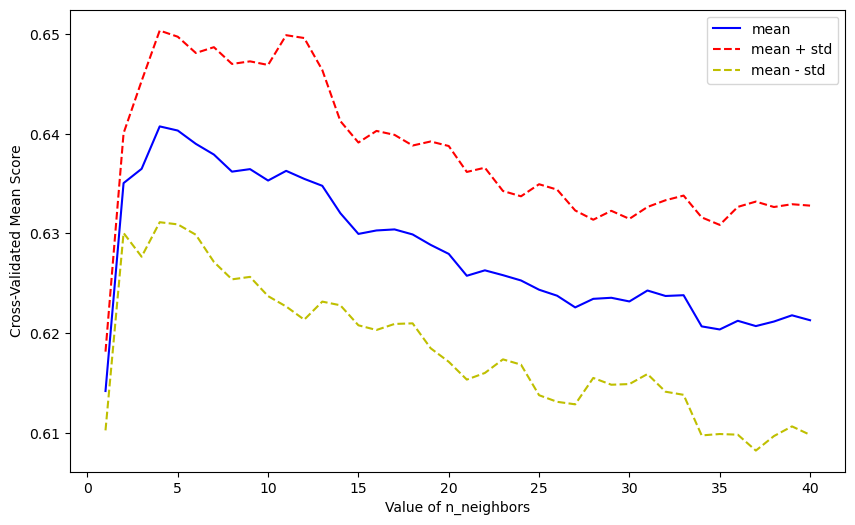

In [19]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(range(1, 41), grid1.cv_results_['mean_test_score'], label = 'mean', c = 'b')
ax.plot(range(1, 41), grid1.cv_results_['mean_test_score'] + grid1.cv_results_['std_test_score'], '--', label = 'mean + std', c = 'r')
ax.plot(range(1, 41), grid1.cv_results_['mean_test_score'] - grid1.cv_results_['std_test_score'], '--', label = 'mean - std', c = 'y')
ax.set_ylabel('Cross-Validated Mean Score')
ax.set_xlabel('Value of n_neighbors')
ax.legend(loc = 1)

`GridSearchCV` и `cross_val_score` c перемешиванием

In [20]:
knn = KNeighborsClassifier()
param_grid = { 'n_neighbors': range(1, 41) }
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid1 = GridSearchCV(knn, param_grid, cv = shuffle, scoring = 'roc_auc')
grid1.fit(X, y)
print(grid1.best_score_)
print(grid1.best_params_)

0.6420641358382506
{'n_neighbors': 6}


In [21]:
knn = KNeighborsClassifier(n_neighbors = grid1.best_params_.get('n_neighbors'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.64971391 0.63453598 0.66035489 0.64508491 0.62063099]
0.6420641358382506
0.013551744301105312


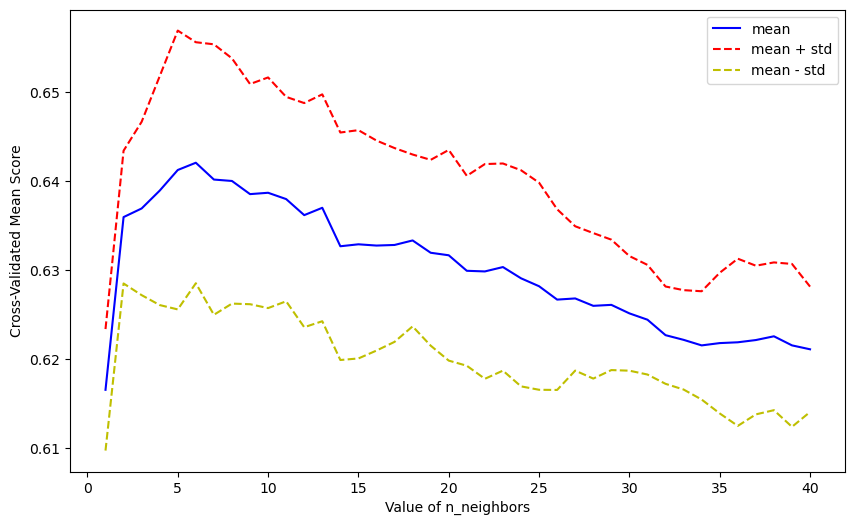

In [22]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(range(1, 41), grid1.cv_results_['mean_test_score'], label = 'mean', c = 'b')
ax.plot(range(1, 41), grid1.cv_results_['mean_test_score'] + grid1.cv_results_['std_test_score'], '--', label = 'mean + std', c = 'r')
ax.plot(range(1, 41), grid1.cv_results_['mean_test_score'] - grid1.cv_results_['std_test_score'], '--', label = 'mean - std', c = 'y')
ax.set_ylabel('Cross-Validated Mean Score')
ax.set_xlabel('Value of n_neighbors')
ax.legend(loc = 1)

In [23]:
knn = KNeighborsClassifier(n_neighbors = grid1.best_params_.get('n_neighbors'))
knn.fit(X_train, y_train)
print(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]))

0.6496225540656764


`DecisionTreeClassifier`

`GridSearchCV` и `cross_val_score` без перемешивания

In [24]:
dtc = DecisionTreeClassifier()
param_grid = { 'max_depth': range(1, 41) }
grid2 = GridSearchCV(dtc, param_grid, cv = 5, scoring = 'roc_auc')
grid2.fit(X, y)
print(grid2.best_score_)
print(grid2.best_params_)

0.841282243338191
{'max_depth': 7}


In [25]:
dtc = DecisionTreeClassifier(max_depth = grid2.best_params_.get('max_depth'))
scores = cross_val_score(dtc, X, y, cv = 5, scoring = 'roc_auc')
mean_score = cross_val_score(dtc, X, y, cv = 5, scoring = 'roc_auc').mean()
std_score = cross_val_score(dtc, X, y, cv = 5, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.84431987 0.83741024 0.83746331 0.84223763 0.84371585]
0.8414390088227284
0.002230102500246668


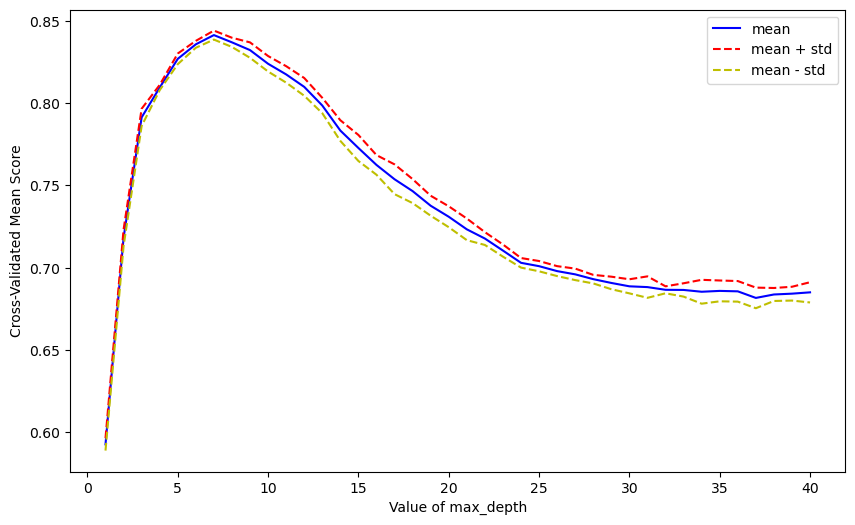

In [26]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(range(1, 41), grid2.cv_results_['mean_test_score'], label = 'mean', c = 'b')
ax.plot(range(1, 41), grid2.cv_results_['mean_test_score'] + grid2.cv_results_['std_test_score'], '--', label = 'mean + std', c = 'r')
ax.plot(range(1, 41), grid2.cv_results_['mean_test_score'] - grid2.cv_results_['std_test_score'], '--', label = 'mean - std', c = 'y')
ax.set_ylabel('Cross-Validated Mean Score')
ax.set_xlabel('Value of max_depth')
ax.legend(loc = 1)

`GridSearchCV` и `cross_val_score` c перемешиванием

In [27]:
dtc = DecisionTreeClassifier()
param_grid = { 'max_depth': range(1, 41) }
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid2 = GridSearchCV(dtc, param_grid, cv = shuffle, scoring = 'roc_auc')
grid2.fit(X, y)
print(grid2.best_score_)
print(grid2.best_params_)

0.8390434603255519
{'max_depth': 7}


In [28]:
dtc = DecisionTreeClassifier(max_depth = grid2.best_params_.get('max_depth'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.83162658 0.83963167 0.84101793 0.83986345 0.84201021]
0.8389479929046649
0.004801063122473379


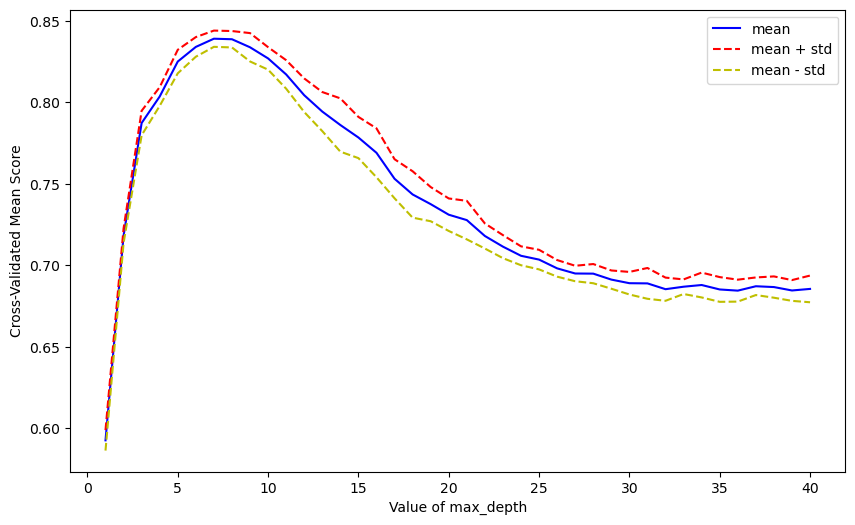

In [29]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(range(1, 41), grid2.cv_results_['mean_test_score'], label = 'mean', c = 'b')
ax.plot(range(1, 41), grid2.cv_results_['mean_test_score'] + grid2.cv_results_['std_test_score'], '--', label = 'mean + std', c = 'r')
ax.plot(range(1, 41), grid2.cv_results_['mean_test_score'] - grid2.cv_results_['std_test_score'], '--', label = 'mean - std', c = 'y')
ax.set_ylabel('Cross-Validated Mean Score')
ax.set_xlabel('Value of max_depth')
ax.legend(loc = 1)

In [30]:
dtc = DecisionTreeClassifier(max_depth = grid2.best_params_.get('max_depth'))
dtc.fit(X_train, y_train)
print(roc_auc_score(y_test, dtc.predict_proba(X_test)[:, 1]))

0.8303559890019296


`SGDClassifier`

`GridSearchCV` и `cross_val_score` без перемешивания

In [31]:
sklearn.__version__

'1.0.2'

Для большей сходимости немного увеличим число итераций. Скорее всего отсутствие сходимости связано с чувствительностью к масштабу признаков.

In [32]:
sgdc = SGDClassifier(max_iter = 7000)
param_grid = { 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron',
                        'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'] }
grid3 = GridSearchCV(sgdc, param_grid, cv = 5, scoring = 'roc_auc')
grid3.fit(X, y)
print(grid3.best_score_)
print(grid3.best_params_)

0.623275815594891
{'loss': 'modified_huber'}


In [33]:
sgdc = SGDClassifier(loss = grid3.best_params_.get('loss'), max_iter = 7000)
scores = cross_val_score(sgdc, X, y, cv = 5, scoring = 'roc_auc')
mean_score = cross_val_score(sgdc, X, y, cv = 5, scoring = 'roc_auc').mean()
std_score = cross_val_score(sgdc, X, y, cv = 5, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.58626466 0.61705045 0.62253119 0.62536803 0.62819456]
0.6095979474562754
0.025220669757944725


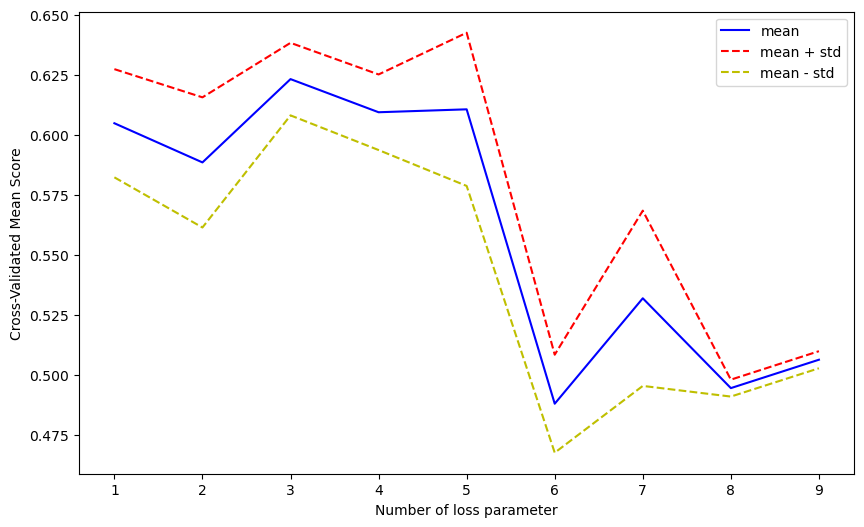

In [34]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(range(1, 10), grid3.cv_results_['mean_test_score'], label = 'mean', c = 'b')
ax.plot(range(1, 10), grid3.cv_results_['mean_test_score'] + grid3.cv_results_['std_test_score'], '--', label = 'mean + std', c = 'r')
ax.plot(range(1, 10), grid3.cv_results_['mean_test_score'] - grid3.cv_results_['std_test_score'], '--', label = 'mean - std', c = 'y')
ax.set_ylabel('Cross-Validated Mean Score')
ax.set_xlabel('Number of loss parameter')
ax.legend(loc = 1)

`GridSearchCV` и `cross_val_score` c перемешиванием

In [35]:
sgdc = SGDClassifier(max_iter = 7000)
param_grid = { 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron',
                        'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'] }
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid3 = GridSearchCV(sgdc, param_grid, cv = shuffle, scoring = 'roc_auc')
grid3.fit(X, y)
print(grid3.best_score_)
print(grid3.best_params_)

0.6327331039288018
{'loss': 'perceptron'}


In [36]:
sgdc = SGDClassifier(loss = grid3.best_params_.get('loss'), max_iter = 7000)
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.62787234 0.62663773 0.59403491 0.612155   0.62420786]
0.6096599851150459
0.022138930903548945


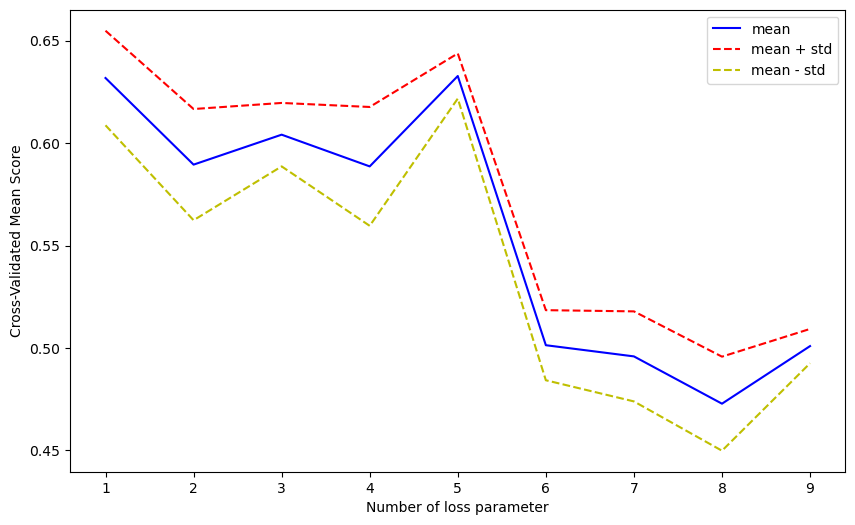

In [37]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(range(1, 10), grid3.cv_results_['mean_test_score'], label = 'mean', c = 'b')
ax.plot(range(1, 10), grid3.cv_results_['mean_test_score'] + grid3.cv_results_['std_test_score'], '--', label = 'mean + std', c = 'r')
ax.plot(range(1, 10), grid3.cv_results_['mean_test_score'] - grid3.cv_results_['std_test_score'], '--', label = 'mean - std', c = 'y')
ax.set_ylabel('Cross-Validated Mean Score')
ax.set_xlabel('Number of loss parameter')
ax.legend(loc = 1)

In [38]:
sgdc = SGDClassifier(loss = grid3.best_params_.get('loss'), max_iter = 7000)
sgdc.fit(X_train, y_train)
print(roc_auc_score(y_test, sgdc.decision_function(X_test)))

0.637768044544859


Что вы можете сказать о получившихся графиках?

Исходя из графиков можно сделать вывод о том, что DecisionTreeClassifier даёт наилучший результат из трёх рассмотренных моделей, KNeighborsClassifier же вместе с SGDClassifier дают примерно одинаковый результат. Также стоит обратить внимание на то, что наибольшее стандартное отклонение наблюдается у SGDClassifier, а наименьшее у DecisionTreeClassifier. Помимо этого можно обратить внимание на последовательное уменьшение auc-метрики после некоторого момента при увеличении значений параметров n_neighbors и max_depth для KNeighborsClassifier и DecisionTreeClassifier. Для SGDClassifier же первые пять значений loss-параметра дают значительно болшее значение auc-метрики.

**Задание 3** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

Установим параметр n_jobs для ускорения обработки GridSearchCV, чтобы показать наглядно на графике стабилизацию auc-метрики при увеличении параметра n_estimators.

In [39]:
rfc = RandomForestClassifier()
param_grid = { 'n_estimators': range(1, 301) }
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid4 = GridSearchCV(rfc, param_grid, cv = shuffle, scoring = 'roc_auc', n_jobs = 5)
grid4.fit(X, y)
print(grid4.best_score_)
print(grid4.best_params_)

0.818038221268
{'n_estimators': 186}


In [40]:
rfc = RandomForestClassifier(n_estimators = grid4.best_params_.get('n_estimators'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.81191177 0.80802745 0.82606227 0.82167287 0.81430914]
0.8158494089531867
0.006693629995539268


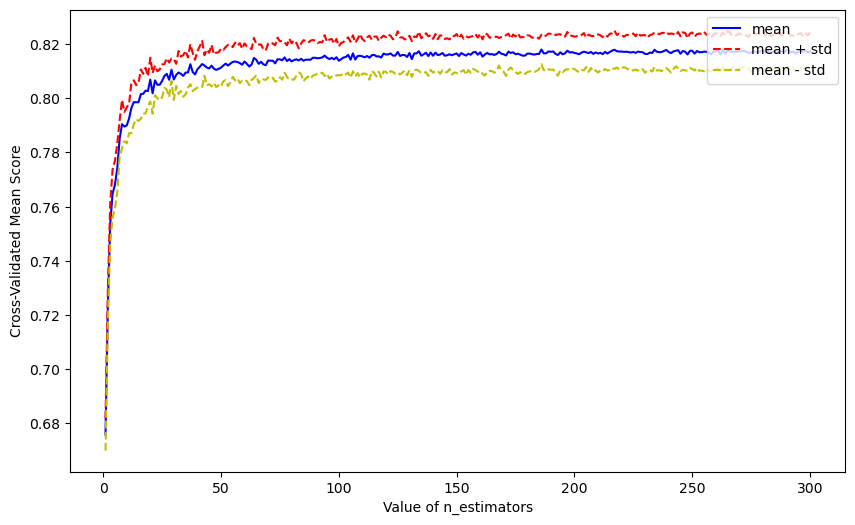

In [41]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(range(1, 301), grid4.cv_results_['mean_test_score'], label = 'mean', c = 'b')
ax.plot(range(1, 301), grid4.cv_results_['mean_test_score'] + grid4.cv_results_['std_test_score'], '--', label = 'mean + std', c = 'r')
ax.plot(range(1, 301), grid4.cv_results_['mean_test_score'] - grid4.cv_results_['std_test_score'], '--', label = 'mean - std', c = 'y')
ax.set_ylabel('Cross-Validated Mean Score')
ax.set_xlabel('Value of n_estimators')
ax.legend(loc = 1)

На графике можно наблюдать, что метрика стабилизируется уже при значении 150 параметра n_estimators. В дальнейшем будем использовать это число деревьев.

In [42]:
rfc = RandomForestClassifier(n_estimators = 150)
rfc.fit(X_train, y_train)
print(roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]))

0.8137458055373592


**Задание 4** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [43]:
gbc = GradientBoostingClassifier()
param_grid = { 'n_estimators': range(1, 701) }
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid5 = GridSearchCV(gbc, param_grid, cv = shuffle, scoring = 'roc_auc', n_jobs = 5)
grid5.fit(X, y)
print(grid5.best_score_)
print(grid5.best_params_)

0.8660306206882684
{'n_estimators': 322}


In [44]:
gbc = GradientBoostingClassifier(n_estimators = grid5.best_params_.get('n_estimators'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.8617983  0.8578408  0.87025849 0.8687069  0.87122412]
0.865962525074637
0.005254854750328437


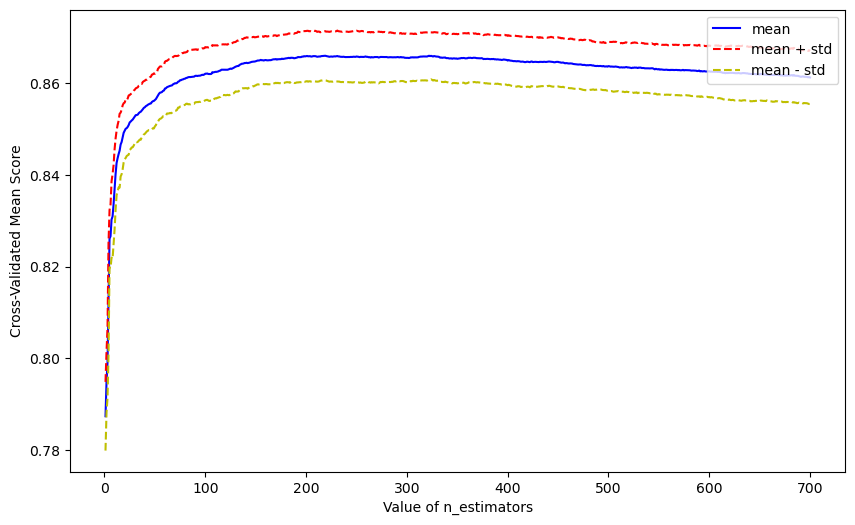

In [45]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(range(1, 701), grid5.cv_results_['mean_test_score'], label = 'mean', c = 'b')
ax.plot(range(1, 701), grid5.cv_results_['mean_test_score'] + grid5.cv_results_['std_test_score'], '--', label = 'mean + std', c = 'r')
ax.plot(range(1, 701), grid5.cv_results_['mean_test_score'] - grid5.cv_results_['std_test_score'], '--', label = 'mean - std', c = 'y')
ax.set_ylabel('Cross-Validated Mean Score')
ax.set_xlabel('Value of n_estimators')
ax.legend(loc = 1)

Действительно по U-образному графику можно наблюдать падение auc-метрики и рост ошибки бустинга при достижении некоторого числа деревьев.

In [46]:
gbc = GradientBoostingClassifier(n_estimators = grid5.best_params_.get('n_estimators'))
gbc.fit(X_train, y_train)
print(roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1]))

0.8616763144877744


При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

In [47]:
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
...,...,...,...,...,...,...
15342,25,514716,13,0,0,40
15343,32,207668,13,15024,0,45
15344,27,104457,13,0,0,40
15345,59,268700,9,0,0,40


Text(0, 0.5, '$\\rho(k)$')

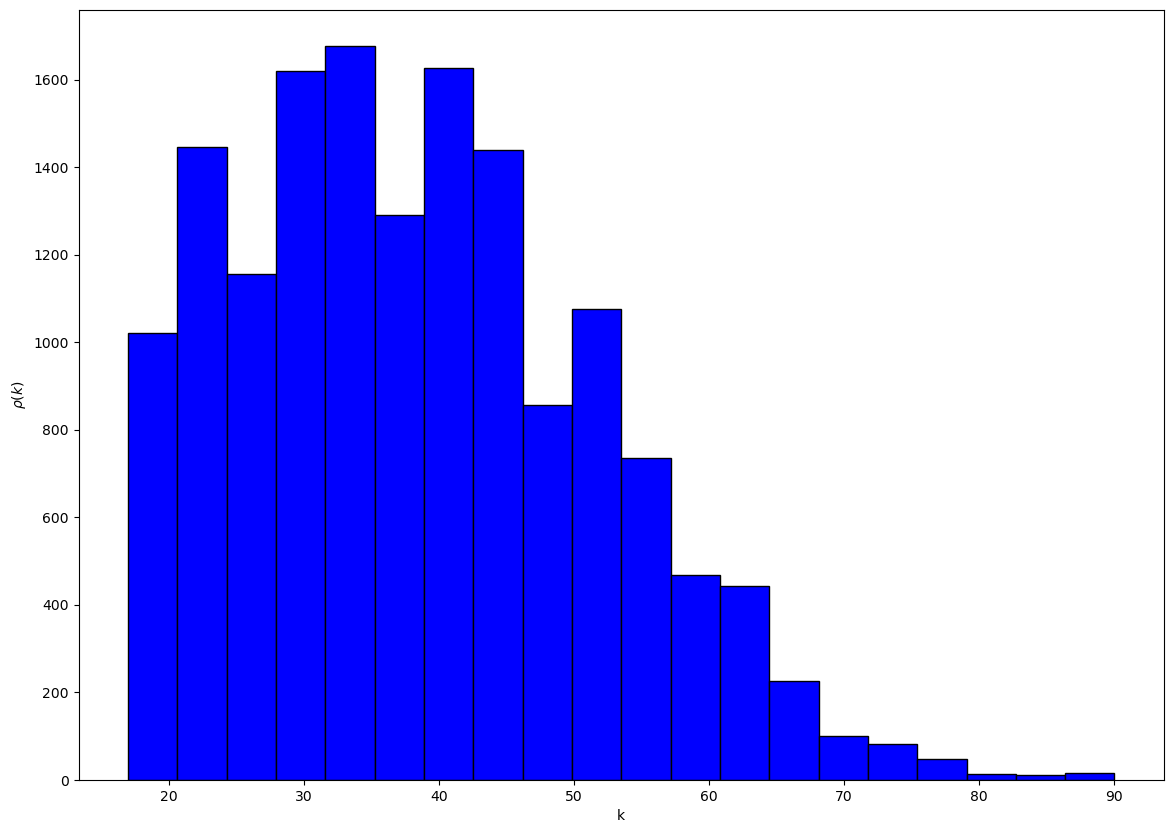

In [48]:
fig, ax = plt.subplots(figsize = (14, 10))
_ = ax.hist(X['age'], edgecolor = 'black', color = 'b', bins = 20)
ax.set_xlabel('k')
ax.set_ylabel(r'$\rho(k)$')

Text(0, 0.5, '$\\rho(k)$')

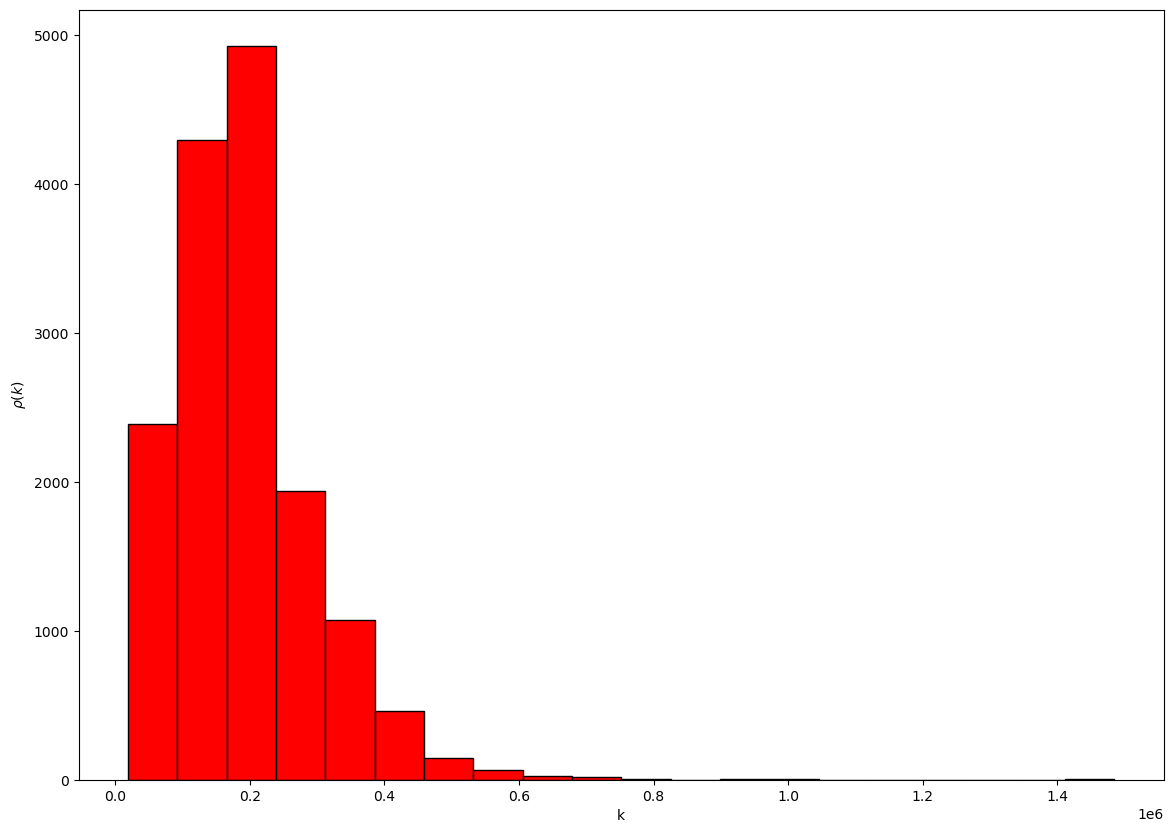

In [49]:
fig, ax = plt.subplots(figsize = (14, 10))
_ = ax.hist(X['fnlwgt'], edgecolor = 'black', color = 'r', bins = 20)
ax.set_xlabel('k')
ax.set_ylabel(r'$\rho(k)$')

Text(0, 0.5, '$\\rho(k)$')

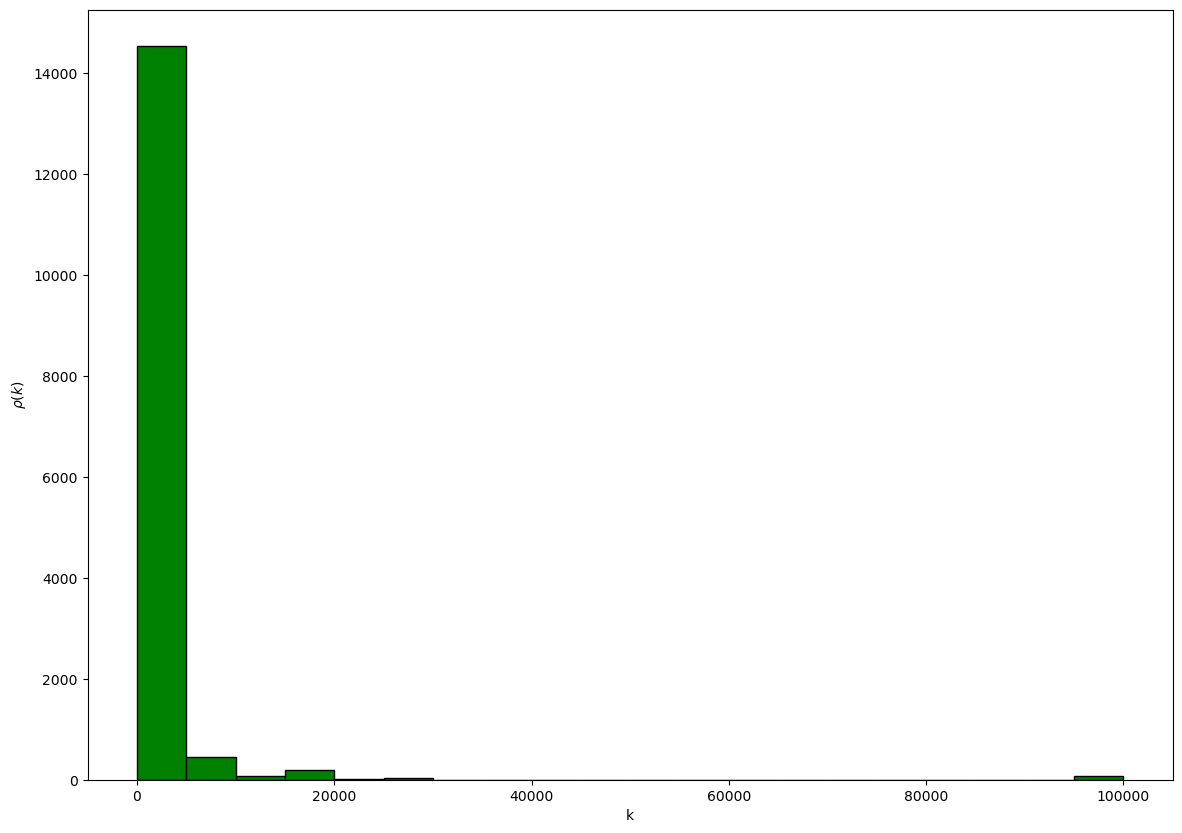

In [50]:
fig, ax = plt.subplots(figsize = (14, 10))
_ = ax.hist(X['capital-gain'], edgecolor = 'black', color = 'g', bins = 20)
ax.set_xlabel('k')
ax.set_ylabel(r'$\rho(k)$')

На данных трёх признаках наблюдается большой разброс по значениям, масштабирование определённо сможет решить эту проблему и позволит получить на вышеприведённых алгоритмах более хороший результат. В особенности масштабирование сможет повлиять на KNeighborsClassifier и SGDClassifier.

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).

**Задание 6** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [51]:
scaler = StandardScaler()
X[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.fit_transform(X[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']])
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178
...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178


In [99]:
X.mean(axis = 0)

age               6.933559e-17
fnlwgt            3.744389e-17
education-num    -1.759197e-16
capital-gain     -7.109131e-16
capital-loss     -1.891177e-15
hours-per-week    1.228574e-16
dtype: float64

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [101]:
knn = KNeighborsClassifier(n_neighbors = grid1.best_params_.get('n_neighbors'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.77796253 0.7864445  0.80136295 0.79530101 0.78765676]
0.7897455499170564
0.00799908311048198


In [102]:
dtc = DecisionTreeClassifier(max_depth = grid2.best_params_.get('max_depth'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.83185246 0.83963167 0.84101793 0.84025341 0.84201021]
0.8384018871568975
0.004135587970968162


In [103]:
sgdc = SGDClassifier(loss = grid3.best_params_.get('loss'), max_iter = 7000)
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.53404784 0.70482656 0.78827256 0.77738307 0.56072199]
0.7100435896974263
0.04376305871677239


In [104]:
rfc = RandomForestClassifier(n_estimators = 150)
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.80972152 0.80928583 0.82279701 0.8214237  0.81619416]
0.8164967045122274
0.006371874049775705


In [105]:
gbc = GradientBoostingClassifier(n_estimators = grid5.best_params_.get('n_estimators'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.86180945 0.8578582  0.87024642 0.86889015 0.87121023]
0.8659855812342541
0.005222230290494454


Изменилось ли качество у некоторых алгоритмов?

Действительно масштабирование позволило получить на вышеприведённых алгоритмах более качественный результат.

**Задание 7** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [106]:
knn = KNeighborsClassifier()
param_grid = { 'n_neighbors': range(1, 41), 'metric': ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
                                                       'cosine', 'euclidean', 'manhattan', 'minkowski', 'sqeuclidean',
                                                       'jaccard', 'kulsinski', 'l2', 'l1', 'yule', 'hamming', 'russellrao'] }
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid6 = GridSearchCV(knn, param_grid, cv = shuffle, scoring = 'roc_auc', n_jobs = 5)
grid6.fit(X, y)
print(grid6.best_score_)
print(grid6.best_params_)

0.8357952957257135
{'metric': 'braycurtis', 'n_neighbors': 40}


In [107]:
knn = KNeighborsClassifier(n_neighbors = grid6.best_params_.get('n_neighbors'), metric = grid6.best_params_.get('metric'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.82649296 0.83297664 0.83820809 0.84457981 0.83671898]
0.8357952957257135
0.005971945993948061


In [108]:
knn = KNeighborsClassifier(n_neighbors = grid6.best_params_.get('n_neighbors'), metric = grid6.best_params_.get('metric'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_validate(knn, X, y, cv = shuffle, scoring = 'roc_auc')
print(np.mean(scores['fit_time']))

0.011392545700073243


In [109]:
dtc = DecisionTreeClassifier()
param_grid = { 'max_depth': range(1, 41), 'criterion': ['gini', 'entropy'] }
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid7 = GridSearchCV(dtc, param_grid, cv = shuffle, scoring = 'roc_auc')
grid7.fit(X, y)
print(grid7.best_score_)
print(grid7.best_params_)

0.8401059219535456
{'criterion': 'entropy', 'max_depth': 8}


In [110]:
dtc = DecisionTreeClassifier(max_depth = grid7.best_params_.get('max_depth'), criterion = grid7.best_params_.get('criterion'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.83163076 0.83720444 0.84378717 0.84661201 0.84403503]
0.8399851352246165
0.006317439532573346


In [111]:
dtc = DecisionTreeClassifier(max_depth = grid7.best_params_.get('max_depth'), criterion = grid7.best_params_.get('criterion'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_validate(dtc, X, y, cv = shuffle, scoring = 'roc_auc')
print(np.mean(scores['fit_time']))

0.022801637649536133


In [112]:
sgdc = SGDClassifier()
param_grid = { 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron',
                        'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'penalty': ['l2',
                        'l1', 'elasticnet', None] }
grid8 = GridSearchCV(sgdc, param_grid, cv = 5, scoring = 'roc_auc')
grid8.fit(X, y)
print(grid8.best_score_)
print(grid8.best_params_)

0.821913343698467
{'loss': 'log', 'penalty': 'elasticnet'}


In [113]:
sgdc = SGDClassifier(loss = grid8.best_params_.get('loss'), penalty = grid8.best_params_.get('penalty'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.81618533 0.82033226 0.82491578 0.82834378 0.81742684]
0.823403565325175
0.004728307710939608


In [114]:
sgdc = SGDClassifier(loss = grid8.best_params_.get('loss'), penalty = grid8.best_params_.get('penalty'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_validate(sgdc, X, y, cv = shuffle, scoring = 'roc_auc')
print(np.mean(scores['fit_time']))

0.03559746742248535


In [115]:
rfc = RandomForestClassifier(n_estimators = 150)
param_grid = { 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2', None] }
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid9 = GridSearchCV(rfc, param_grid, cv = shuffle, scoring = 'roc_auc', n_jobs = 5)
grid9.fit(X, y)
print(grid9.best_score_)
print(grid9.best_params_)

0.8184754431667425
{'criterion': 'entropy', 'max_features': None}


In [116]:
rfc = RandomForestClassifier(n_estimators = 150, criterion = grid9.best_params_.get('criterion'),
                             max_features = grid9.best_params_.get('max_features'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.81555477 0.80865776 0.82877609 0.81751994 0.81770145]
0.8180814008296611
0.006235247494640804


In [117]:
rfc = RandomForestClassifier(n_estimators = 150, criterion = grid9.best_params_.get('criterion'),
                             max_features = grid9.best_params_.get('max_features'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_validate(rfc, X, y, cv = shuffle, scoring = 'roc_auc')
print(np.mean(scores['fit_time']))

4.0071769714355465


In [118]:
gbc = GradientBoostingClassifier(n_estimators = grid5.best_params_.get('n_estimators'))
param_grid = { 'criterion': ['friedman_mse', 'squared_error'], 'max_features': ['sqrt', 'log2', None] }
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid10 = GridSearchCV(gbc, param_grid, cv = shuffle, scoring = 'roc_auc', n_jobs = 5)
grid10.fit(X, y)
print(grid10.best_score_)
print(grid10.best_params_)

0.8667496423022196
{'criterion': 'friedman_mse', 'max_features': 'sqrt'}


In [119]:
gbc = GradientBoostingClassifier(n_estimators = grid5.best_params_.get('n_estimators'),
                                 criterion = grid10.best_params_.get('criterion'),
                                 max_features = grid10.best_params_.get('max_features'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.86146381 0.85755006 0.86838197 0.87213133 0.87066351]
0.8662362760342951
0.0053326210720989736


In [120]:
gbc = GradientBoostingClassifier(n_estimators = grid5.best_params_.get('n_estimators'),
                                 criterion = grid10.best_params_.get('criterion'),
                                 max_features = grid10.best_params_.get('max_features'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_validate(gbc, X, y, cv = shuffle, scoring = 'roc_auc')
print(np.mean(scores['fit_time']))

1.1391858100891112


Какой из алгоритмов имеет наилучшее качество?

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

Алгоритм GradientBoostingClassifier имеет наилучшее качество. Дольше всего работает обучение RandomForestClassifier. Это скорее всего связано с обучением большого числа деревьев.

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков.

**Задание 9** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [121]:
dfo

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
15343,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
15344,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
15345,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


In [122]:
dfc = dfo
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15347 entries, 0 to 15346
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
 13  >50K,<=50K      15347 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.6+ MB


In [123]:
dfc = dfc.drop(columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', '>50K,<=50K'])
dfc

,workclass,education,marital-status,occupation,relationship,race,sex
0,Local-gov,HS-grad,Never-married,Farming-fishing,Not-in-family,Black,Male
1,Private,Some-college,Divorced,Sales,Not-in-family,White,Male
2,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Own-child,White,Male
3,Private,Some-college,Never-married,Sales,Own-child,White,Female
4,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,Male
...,...,...,...,...,...,...,...
15342,Local-gov,Bachelors,Never-married,Adm-clerical,Own-child,Black,Female
15343,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male
15344,Private,Bachelors,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male
15345,State-gov,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male


In [124]:
dfc = pd.get_dummies(dfc, columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
dfc

,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
15343,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
15344,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
15345,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


**Задание 10** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [125]:
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178
...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178


In [126]:
X = pd.concat([X, dfc], axis = 1)
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379,0,0,1,0,...,1,0,0,0,0,0,0,1,1,0
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [127]:
knn = KNeighborsClassifier(n_neighbors = grid6.best_params_.get('n_neighbors'), metric = grid6.best_params_.get('metric'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(knn, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.88795716 0.89348647 0.8921518  0.89197503 0.89445334]
0.8920047595086874
0.0022179538952132915


In [128]:
dtc = DecisionTreeClassifier(max_depth = grid7.best_params_.get('max_depth'), criterion = grid7.best_params_.get('criterion'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(dtc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.8870996  0.89623335 0.89041218 0.89163731 0.89659407]
0.89225749471275
0.002826231605882406


In [129]:
sgdc = SGDClassifier(loss = grid8.best_params_.get('loss'), penalty = grid8.best_params_.get('penalty'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(sgdc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.90296754 0.89941801 0.90305895 0.89961105 0.90123352]
0.9020312744299144
0.0015476930127391163


In [130]:
rfc = RandomForestClassifier(n_estimators = 150, criterion = grid9.best_params_.get('criterion'),
                             max_features = grid9.best_params_.get('max_features'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(rfc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.90232445 0.89660744 0.90430832 0.90004095 0.90289396]
0.9020664514554874
0.0031662372928529703


In [131]:
gbc = GradientBoostingClassifier(n_estimators = grid5.best_params_.get('n_estimators'),
                                 criterion = grid10.best_params_.get('criterion'),
                                 max_features = grid10.best_params_.get('max_features'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(gbc, X, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.92008797 0.91923913 0.92206725 0.91916256 0.92049174]
0.9198356920004688
0.0015370486384407806


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

Да, отличается. У всех классификаторов выросла метрика качества.

## Поиск новых полезных признаков

**Задание 11** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей?

In [242]:
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379,0,0,1,0,...,1,0,0,0,0,0,0,1,1,0
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [243]:
Xp = pd.DataFrame(X[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']])
Xp

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178
...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178


In [244]:
poly = PolynomialFeatures(degree = 2)

In [245]:
Xp = pd.DataFrame(poly.fit_transform(Xp))
Xp

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223,0.117593,-0.308715,0.154583,...,0.203210,0.029571,0.098605,-0.715952,0.004303,0.014349,-0.104187,0.047847,-0.347409,2.522452
1,1.0,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178,0.013170,0.001226,-0.006781,...,0.003491,0.008889,0.012924,0.004383,0.022632,0.032907,0.011159,0.047847,0.016226,0.005502
2,1.0,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178,0.036237,0.020231,-0.212444,...,1.245501,-0.167893,-0.244119,-0.082784,0.022632,0.032907,0.011159,0.047847,0.016226,0.005502
3,1.0,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379,1.583258,0.052070,0.074346,...,0.003491,0.008889,0.012924,0.053495,0.022632,0.032907,0.136204,0.047847,0.198043,0.819711
4,1.0,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178,0.420836,-0.240802,0.723983,...,1.245501,2.226896,-0.244119,-0.082784,3.981586,-0.436473,-0.148014,0.047847,0.016226,0.005502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,1.0,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178,1.059739,-3.153116,-1.148872,...,1.245501,-0.167893,-0.244119,-0.082784,0.022632,0.032907,0.011159,0.047847,0.016226,0.005502
15343,1.0,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422,0.245498,-0.086302,-0.552963,...,1.245501,2.226896,-0.244119,0.381034,3.981586,-0.436473,0.681271,0.047847,-0.074683,0.116569
15344,1.0,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178,0.768913,0.698742,-0.978612,...,1.245501,-0.167893,-0.244119,-0.082784,0.022632,0.032907,0.011159,0.047847,0.016226,0.005502
15345,1.0,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178,2.446333,1.170525,-0.705066,...,0.203210,0.067816,0.098605,0.033439,0.022632,0.032907,0.011159,0.047847,0.016226,0.005502


In [246]:
from sklearn.feature_selection import RFECV

In [247]:
gbc = GradientBoostingClassifier(n_estimators = grid5.best_params_.get('n_estimators'),
                                 criterion = grid10.best_params_.get('criterion'),
                                 max_features = grid10.best_params_.get('max_features'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
rfecv = RFECV(gbc, step = 1, cv = shuffle, scoring = 'roc_auc', n_jobs = 5)
rfecv = rfecv.fit(Xp, y)

In [248]:
rfecv.n_features_

10

In [249]:
rfecv.support_

array([False,  True, False,  True,  True,  True,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True,  True, False, False,
       False])

In [250]:
rfecv.ranking_

array([19,  1,  7,  1,  1,  1,  1, 12, 13,  8,  1,  4,  6, 11, 14, 16, 15,
       10, 17,  2,  1,  5,  1,  1,  1,  3,  9, 18])

In [251]:
msk = pd.DataFrame(rfecv.support_, index = Xp.columns, columns = ['mask'])
msk['bool'] = pd.factorize(msk['mask'])[0]
msk = msk.drop(columns = ['mask'])
msk

,bool
0,0
1,1
2,0
3,1
4,1
5,1
6,1
7,0
8,0
9,0


In [252]:
indx = msk[msk['bool'] == 1].index.tolist()
print(indx)

[1, 3, 4, 5, 6, 10, 20, 22, 23, 24]


In [253]:
Xp = Xp.filter(indx)
Xp

,1,3,4,5,6,10,20,22,23,24
0,-0.342919,-0.450788,-0.065600,-0.218740,1.588223,0.022495,0.098605,0.004303,0.014349,-0.104187
1,0.114760,-0.059086,-0.150439,-0.218740,-0.074178,-0.017264,0.012924,0.022632,0.032907,0.011159
2,-0.190359,1.116020,-0.150439,-0.218740,-0.074178,0.028637,-0.244119,0.022632,0.032907,0.011159
3,-1.258276,-0.059086,-0.150439,-0.218740,-0.905379,0.189293,0.012924,0.022632,0.032907,0.136204
4,0.648719,1.116020,1.995391,-0.218740,-0.074178,1.294447,-0.244119,3.981586,-0.436473,-0.148014
...,...,...,...,...,...,...,...,...,...,...
15342,-1.029436,1.116020,-0.150439,-0.218740,-0.074178,0.154867,-0.244119,0.022632,0.032907,0.011159
15343,-0.495478,1.116020,1.995391,-0.218740,0.341422,-0.988672,-0.244119,3.981586,-0.436473,0.681271
15344,-0.876877,1.116020,-0.150439,-0.218740,-0.074178,0.131916,-0.244119,0.022632,0.032907,0.011159
15345,1.564076,-0.450788,-0.150439,-0.218740,-0.074178,-0.235297,0.098605,0.022632,0.032907,0.011159


In [254]:
dfc

,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
15343,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
15344,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
15345,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [255]:
Xp = pd.concat([Xp, dfc], axis = 1)
Xp

,1,3,4,5,6,10,20,22,23,24,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,-0.342919,-0.450788,-0.065600,-0.218740,1.588223,0.022495,0.098605,0.004303,0.014349,-0.104187,...,0,0,0,0,0,1,0,0,0,1
1,0.114760,-0.059086,-0.150439,-0.218740,-0.074178,-0.017264,0.012924,0.022632,0.032907,0.011159,...,0,0,0,0,0,0,0,1,0,1
2,-0.190359,1.116020,-0.150439,-0.218740,-0.074178,0.028637,-0.244119,0.022632,0.032907,0.011159,...,1,0,0,0,0,0,0,1,0,1
3,-1.258276,-0.059086,-0.150439,-0.218740,-0.905379,0.189293,0.012924,0.022632,0.032907,0.136204,...,1,0,0,0,0,0,0,1,1,0
4,0.648719,1.116020,1.995391,-0.218740,-0.074178,1.294447,-0.244119,3.981586,-0.436473,-0.148014,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,-1.029436,1.116020,-0.150439,-0.218740,-0.074178,0.154867,-0.244119,0.022632,0.032907,0.011159,...,1,0,0,0,0,1,0,0,1,0
15343,-0.495478,1.116020,1.995391,-0.218740,0.341422,-0.988672,-0.244119,3.981586,-0.436473,0.681271,...,0,0,0,0,0,0,0,1,0,1
15344,-0.876877,1.116020,-0.150439,-0.218740,-0.074178,0.131916,-0.244119,0.022632,0.032907,0.011159,...,0,0,0,0,1,0,0,0,0,1
15345,1.564076,-0.450788,-0.150439,-0.218740,-0.074178,-0.235297,0.098605,0.022632,0.032907,0.011159,...,0,0,0,0,0,0,0,1,0,1


In [256]:
Xp.columns = Xp.columns.astype(str)

In [257]:
knn = KNeighborsClassifier(n_neighbors = grid6.best_params_.get('n_neighbors'), metric = grid6.best_params_.get('metric'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(knn, Xp, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(knn, Xp, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(knn, Xp, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.89520305 0.90210736 0.90470475 0.89981105 0.90180303]
0.9007258479749414
0.0031698166868361767


In [258]:
dtc = DecisionTreeClassifier(max_depth = grid7.best_params_.get('max_depth'), criterion = grid7.best_params_.get('criterion'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(dtc, Xp, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(dtc, Xp, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(dtc, Xp, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.89070445 0.89335485 0.89059599 0.89254684 0.89890823]
0.8937831002908926
0.002861134294935411


In [259]:
sgdc = SGDClassifier(loss = grid8.best_params_.get('loss'), penalty = grid8.best_params_.get('penalty'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(sgdc, Xp, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(sgdc, Xp, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(sgdc, Xp, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.90468125 0.90537285 0.90197172 0.90050968 0.90319914]
0.9027743295939376
0.0023193048739615814


In [260]:
rfc = RandomForestClassifier(n_estimators = 150, criterion = grid9.best_params_.get('criterion'),
                             max_features = grid9.best_params_.get('max_features'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(rfc, Xp, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(rfc, Xp, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(rfc, Xp, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.89341692 0.88971864 0.8972464  0.89716906 0.8954078 ]
0.8939088722091582
0.0030682439917643083


In [261]:
gbc = GradientBoostingClassifier(n_estimators = grid5.best_params_.get('n_estimators'),
                                 criterion = grid10.best_params_.get('criterion'),
                                 max_features = grid10.best_params_.get('max_features'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(gbc, Xp, y, cv = shuffle, scoring = 'roc_auc')
mean_score = cross_val_score(gbc, Xp, y, cv = shuffle, scoring = 'roc_auc').mean()
std_score = cross_val_score(gbc, Xp, y, cv = shuffle, scoring = 'roc_auc').std()
print(scores)
print(mean_score)
print(std_score)

[0.92282941 0.92254082 0.92609683 0.92130705 0.92252324]
0.923367376069231
0.0015638444724694381


Да, этот подход позволил немного улучшить качество некоторых моделей.

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [262]:
knn = KNeighborsClassifier(n_neighbors = grid6.best_params_.get('n_neighbors'), metric = grid6.best_params_.get('metric'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores1 = cross_val_score(knn, Xp, y, cv = shuffle, scoring = 'roc_auc')
print(scores1)

[0.89520305 0.90210736 0.90470475 0.89981105 0.90180303]


In [263]:
dtc = DecisionTreeClassifier(max_depth = grid7.best_params_.get('max_depth'), criterion = grid7.best_params_.get('criterion'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores2 = cross_val_score(dtc, Xp, y, cv = shuffle, scoring = 'roc_auc')
print(scores2)

[0.89108574 0.89435757 0.89086265 0.89190464 0.89825784]


In [264]:
sgdc = SGDClassifier(loss = grid8.best_params_.get('loss'), penalty = grid8.best_params_.get('penalty'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores3 = cross_val_score(sgdc, Xp, y, cv = shuffle, scoring = 'roc_auc')
print(scores3)

[0.90589169 0.90483347 0.90241067 0.89835039 0.90107676]


In [265]:
rfc = RandomForestClassifier(n_estimators = 150, criterion = grid9.best_params_.get('criterion'),
                             max_features = grid9.best_params_.get('max_features'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores4 = cross_val_score(rfc, Xp, y, cv = shuffle, scoring = 'roc_auc')
print(scores4)

[0.89305318 0.88860984 0.89692376 0.89641904 0.89565489]


In [266]:
gbc = GradientBoostingClassifier(n_estimators = grid5.best_params_.get('n_estimators'),
                                 criterion = grid10.best_params_.get('criterion'),
                                 max_features = grid10.best_params_.get('max_features'))
shuffle = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores5 = cross_val_score(gbc, Xp, y, cv = shuffle, scoring = 'roc_auc')
print(scores5)

[0.92305417 0.92249283 0.9255668  0.92274537 0.92215329]


[Text(1, 0, 'KNN'),
 Text(2, 0, 'DTC'),
 Text(3, 0, 'SGDC'),
 Text(4, 0, 'RFC'),
 Text(5, 0, 'GBC')]

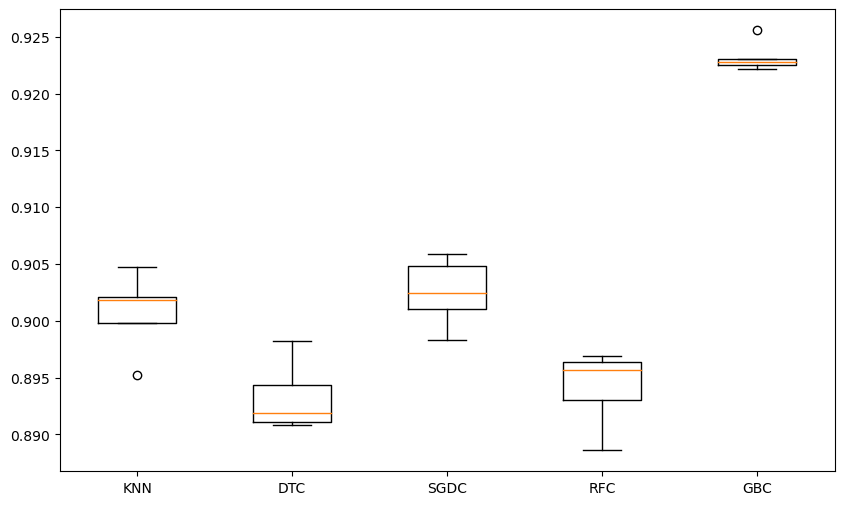

In [270]:
fig, ax = plt.subplots(figsize = (10, 6))
my_dict = {'KNN': scores1, 'DTC': scores2, 'SGDC': scores3, 'RFC': scores4, 'GBC': scores5}
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())

Выводы по классификаторам:

1) KNeighborsClassifier. Для него были подобраны n_neighbors и metric признаки. Изначально подбор n_neighbors дал не очень хороший результат на метрике качества (0.6). На масштабированных данных алгоритм дал намного лучший результат (0.8). После подбора признаков n_neighbors и metric алгоритм дал более хороший результат (0.84). После подбора категориальных признаков алгоритм дал ещё более хороший результат (0.89). После жадного отбора признаков алгоритм дал примерно такой же результат (0.9).

2) DecisionTreeClassifier. Для него были подобраны max_depth и criterion признаки. Изначально подбор max_depth дал достаточно хороший результат на метрике качества (0.8). На масштабированных данных алгоритм дал более хороший результат (0.85). После подбора признаков max_depth и criterion алгоритм дал примерно такой же результат (0.84). После подбора категориальных признаков алгоритм дал ещё более хороший результат (0.89). После жадного отбора признаков алгоритм дал примерно такой же результат (0.89).

3) SGDClassifier. Для него были подобраны loss и penalty признаки. Изначально подбор loss дал не очень хороший результат на метрике качества (0.6). На масштабированных данных алгоритм дал более хороший результат (0.7). После подбора признаков loss и penalty алгоритм дал более хороший результат (0.82). После подбора категориальных признаков алгоритм дал ещё более хороший результат (0.9). После жадного отбора признаков алгоритм дал примерно такой же результат (0.9).

4) RandomForestClassifier. Для него были подобраны n_estimators, criterion и max_features признаки. Изначально подбор n_estimators дал достаточно хороший результат на метрике качества (0.8). На масштабированных данных алгоритм дал примерно такой же результат (0.8). После подбора признаков criterion и max_features вместе с ранее подобранным n_estimators алгоритм дал ещё примерно такой же результат (0.82). После подбора категориальных признаков алгоритм дал более хороший результат (0.9). После жадного отбора признаков алгоритм дал примерно такой же результат (0.89).

5) GradientBoostingClassifier. Для него были подобраны n_estimators, criterion и max_features признаки. Изначально подбор n_estimators дал вполне хороший результат на метрике качества (0.85). На масштабированных данных алгоритм дал примерно такой же результат (0.87). После подбора признаков criterion и max_features вместе с ранее подобранным n_estimators алгоритм дал ещё примерно такой же результат (0.87). После подбора категориальных признаков алгоритм дал более хороший результат (0.92). После жадного отбора признаков алгоритм дал примерно такой же результат (0.92).

GradientBoostingClassifier, как видно из графика, дал максимальный результат на метрике качества.